In [37]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

fc = pd.read_csv('data/forecast.csv')
tf2Key = pd.read_csv('data/tf2Key.csv')


fc = fc[['dates','80%_lower','.mean','80%_upper']]

fc = fc.rename(columns={'.mean': 'price', 'dates': 'date', '80%_lower': 'lower', '80%_upper': 'upper'})
fc['date'] = pd.to_datetime(fc['date'])
tf2Key = tf2Key[['dates','avgVal']]

tf2Key['dates'] = pd.to_datetime(tf2Key['dates'])
tf2Key = tf2Key.rename(columns={'dates': 'date', 'avgVal': 'price'}) 
tf2Key.dropna(inplace=True)  

fc = pd.concat([tf2Key,fc], axis=0)

C:\Users\emant\AppData\Local\Temp\ipykernel_10880\2770256803.py:13: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



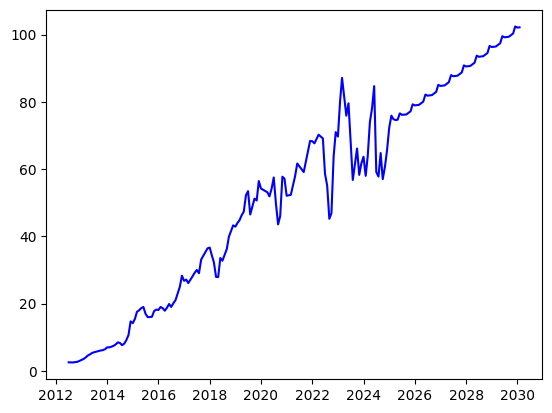

In [38]:
plt.plot(fc['date'], fc['price'], c='blue', label='Forecast')
plt.show()

In [39]:
fc.to_csv('data/graph.csv', index=False)

In [40]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Ensure 'date' is datetime
df = fc.copy()
df['date'] = pd.to_datetime(df['date'])

# Define forecast start
forecast_start = pd.Timestamp('2025-02-01')
df['is_forecast'] = df['date'] >= forecast_start

# Split historical and forecast
df_hist = df[df['is_forecast'] == False]
df_fore = df[df['is_forecast'] == True]

# Create the main historical trace
trace_hist = go.Scatter(
    x=df_hist['date'],
    y=df_hist['price'],
    mode='lines+markers',
    name='Price History',
    line=dict(color='blue'),
    hovertemplate='%{y:.2f}',
)

# Bridge last hist point to forecast
bridge_point = df_hist.iloc[[-1]]
df_fore_with_bridge = pd.concat([bridge_point, df_fore]).sort_values('date')

trace_fore = go.Scatter(
    x=df_fore_with_bridge['date'],
    y=df_fore_with_bridge['price'],
    mode='lines+markers',
    name='Forecast',
    line=dict(color='green', dash='dash'),
    hovertemplate=(
        '%{y:.2f}<br>'
        'Upper: %{customdata[0]:.2f}<br>'
        'Lower: %{customdata[1]:.2f}'
    ),
    customdata=np.stack((
        df_fore_with_bridge['upper'],
        df_fore_with_bridge['lower']
    ), axis=-1),
)


# Confidence interval band (for forecast only)
trace_ci = go.Scatter(
    x=pd.concat([df_fore['date'], df_fore['date'][::-1]]),
    y=pd.concat([df_fore['upper'], df_fore['lower'][::-1]]),
    fill='toself',
    fillcolor='rgba(0, 128, 0, 0.2)',  # green with opacity
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo='skip',
    name='80% CI',
    showlegend=True
)

# Highlight the first forecasted point where price >= 100
highlight_point = df_fore[df_fore['price'] >= 100]
trace_special = go.Scatter()
if not highlight_point.empty:
    first_hit = highlight_point.iloc[0]
    trace_special = go.Scatter(
        x=[first_hit['date']],
        y=[first_hit['price']],
        mode='markers',
        name='Forecast = 100',
        marker=dict(color='red', size=10),
        hovertemplate='',
    )

# Combine all traces
fig = go.Figure([trace_hist, trace_fore, trace_ci, trace_special])

# Layout
fig.update_layout(
    title='Tf2 Key Price Forecast in Refined Metal',
    xaxis_title='Date',
    yaxis_title='Price (in Refined Metal)',
    legend_title='',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1,
    ),
    hovermode='x unified',
    template='seaborn',
)

# Save as interactive HTML
output_path = "index.html"
fig.write_html(output_path, include_plotlyjs='cdn')
output_path


'index.html'